In [1]:
#https://github.com/snorkel-team/snorkel-tutorials/blob/master/spam/01_spam_tutorial.ipynb

In [2]:
%matplotlib inline

import os

# Make sure we're running from the spam/ directory
if os.path.basename(os.getcwd()) == "snorkel-tutorials":
    os.chdir("spam")

# Turn off TensorFlow logging messages
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# For reproducibility
os.environ["PYTHONHASHSEED"] = "0"

In [3]:
import pandas as pd


DISPLAY_ALL_TEXT = False

pd.set_option("display.max_colwidth", 0 if DISPLAY_ALL_TEXT else 50)

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import tensorflow as tf
from sklearn.model_selection import train_test_split
import glob
from snorkel.classification.data import DictDataset, DictDataLoader


def load_spam_dataset(load_train_labels: bool = False, split_dev: bool = True):
    
    filenames = sorted(glob.glob("data/Youtube*.csv"))

    dfs = []
    for i, filename in enumerate(filenames, start=1):
        df = pd.read_csv(filename)
        # Lowercase column names
        df.columns = map(str.lower, df.columns)
        # Remove comment_id field
        df = df.drop("comment_id", axis=1)
        # Add field indicating source video
        df["video"] = [i] * len(df)
        # Rename fields
        df = df.rename(columns={"class": "label", "content": "text"})
        # Shuffle order
        df = df.sample(frac=1, random_state=123).reset_index(drop=True)
        dfs.append(df)

    df_train = pd.concat(dfs[:4])

    if split_dev:
        df_dev = df_train.sample(100, random_state=123)

    if not load_train_labels:
        df_train["label"] = np.ones(len(df_train["label"])) * -1
    df_valid_test = dfs[4]
    df_valid, df_test = train_test_split(
        df_valid_test, test_size=250, random_state=123, stratify=df_valid_test.label
    )

    if split_dev:
        return df_train, df_dev, df_valid, df_test
    else:
        return df_train, df_valid, df_test




In [5]:


df_train, df_dev, df_valid, df_test = load_spam_dataset()

# We pull out the label vectors for ease of use later
Y_dev = df_dev.label.values
Y_valid = df_valid.label.values
Y_test = df_test.label.values

In [6]:
df_train

,author,date,text,label,video
0,Alessandro leite,2014-11-05T22:21:36,pls http://www10.vakinha.com.br/VaquinhaE.aspx...,-1.0,1
1,Salim Tayara,2014-11-02T14:33:30,"if your like drones, plz subscribe to Kamal Ta...",-1.0,1
2,Phuc Ly,2014-01-20T15:27:47,go here to check the views :3﻿,-1.0,1
3,DropShotSk8r,2014-01-19T04:27:18,"Came here to check the views, goodbye.﻿",-1.0,1
4,css403,2014-11-07T14:25:48,"i am 2,126,492,636 viewer :D﻿",-1.0,1
5,Giang Nguyen,2014-11-06T04:55:41,https://www.facebook.com/teeLaLaLa﻿,-1.0,1
6,Caius Ballad,2014-11-13T00:58:20,imagine if this guy put adsense on with all th...,-1.0,1
7,Holly,2014-11-06T13:41:30,Follow me on Twitter @mscalifornia95﻿,-1.0,1
8,King uzzy,2014-11-07T23:19:08,Can we reach 3 billion views by December 2014? ﻿,-1.0,1
9,iKap Taz,2014-11-08T13:34:27,Follow 4 Follow @ Va...,-1.0,1


In [7]:
df_dev.sample(5, random_state=3)

,author,date,text,label,video
128,Pepe The Meme King,2015-05-19T03:49:29.427000,everyday I&#39;m shufflin﻿,0,3
151,Melissa Erhart,NaN,Check out this playlist on YouTube:chcfcvzfzfb...,1,4
31,Angel,2014-11-02T17:27:09,"Hi there~I'm group leader of Angel, a rookie K...",1,1
29,Sandeep Singh,2015-05-23T17:51:58.957000,Charlie from LOST﻿,0,4
237,BigBird Larry,2015-05-24T09:48:00.835000,Every single one of his songs brings me back t...,0,4


In [8]:
# For clarity, we define constants to represent the class labels for spam, ham, and abstaining.
ABSTAIN = -1
HAM = 0
SPAM = 1

print(f"Dev SPAM frequency: {100 * (df_dev.label.values == SPAM).mean():.1f}%")

Dev SPAM frequency: 54.0%


In [9]:

df_train[["author", "text", "video"]].sample(20, random_state=2)

,author,text,video
4,ambareesh nimkar,"""eye of the tiger"" ""i am the champion"" seems l...",2
87,pratik patel,"mindblowing dance.,.,.superbbb song﻿",3
14,RaMpAgE420,Check out Berzerk video on my channel ! :D,4
80,Jason Haddad,"Hey, check out my new website!! This site is a...",1
104,austin green,Eminem is my insperasen and fav﻿,4
305,M.E.S,hey guys look im aware im spamming and it piss...,4
22,John Monster,Οh my god ... Roar is the most liked video at ...,2
338,Alanoud Alsaleh,I started hating Katy Perry after finding out ...,2
336,Leonardo Baptista,http://www.avaaz.org/po/petition/Youtube_Corpo...,1
143,UKz DoleSnacher,Remove This video its wank﻿,1


In [10]:
from snorkel.labeling import labeling_function


@labeling_function()
def check(x):
    return SPAM if "check" in x.text.lower() else ABSTAIN


@labeling_function()
def check_out(x):
    return SPAM if "check out" in x.text.lower() else ABSTAIN

In [11]:
from snorkel.labeling import PandasLFApplier

lfs = [check_out, check]


In [12]:

applier = PandasLFApplier(lfs=lfs)


In [13]:
import pandas
print(pandas.__version__)

0.24.0


In [14]:
L_train = applier.apply(df=df_train)
L_dev = applier.apply(df=df_dev)

100%|██████████| 100/100 [00:00<00:00, 5896.67it/s]


In [15]:
L_train

array([[-1, -1],
       [-1, -1],
       [-1,  1],
       ...,
       [ 1,  1],
       [-1,  1],
       [ 1,  1]])

In [16]:
from snorkel.labeling.apply.dask import PandasParallelLFApplier

In [22]:
applier_pll = PandasParallelLFApplier(lfs=lfs)

In [23]:
L_train2 = applier_pll.apply(df_train, n_parallel=8)

In [24]:
np.array_equal(L_train, L_train2)

False

In [16]:
coverage_check_out, coverage_check = (L_train != ABSTAIN).mean(axis=0)
print(f"check_out coverage: {coverage_check_out * 100:.1f}%")
print(f"check coverage: {coverage_check * 100:.1f}%")

check_out coverage: 21.4%
check coverage: 25.8%


In [17]:
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
check_out,0,[1],0.214376,0.214376,0.0
check,1,[1],0.257881,0.214376,0.0


In [25]:
LFAnalysis(L=L_train2, lfs=lfs).lf_summary()

NameError: name 'LFAnalysis' is not defined

In [18]:
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y=Y_dev)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
check_out,0,[1],0.22,0.22,0.0,22,0,1.000000
check,1,[1],0.30,0.22,0.0,29,1,0.966667


In [19]:

from snorkel.analysis import get_label_buckets

buckets = get_label_buckets(Y_dev, L_dev[:, 1])
df_dev.iloc[buckets[(HAM, SPAM)]]

,author,date,text,label,video
260,Eanna Cusack,2014-01-20T22:20:59,Im just to check how much views it has﻿,0,1


In [20]:
df_train.iloc[L_train[:, 1] == SPAM].sample(10, random_state=1)

,author,date,text,label,video
305,M.E.S,NaN,hey guys look im aware im spamming and it piss...,-1.0,4
265,Kawiana Lewis,2015-02-27T02:20:40.987000,Check out this video on YouTube:opponents mm <...,-1.0,3
89,Stricker Stric,NaN,eminem new song check out my videos,-1.0,4
147,TheGenieBoy,NaN,check out fantasy music right here -------&...,-1.0,4
240,Made2Falter,2014-09-09T23:55:30,"Check out our vids, our songs are awesome! And...",-1.0,2
273,Artady,2014-08-11T16:27:55,https://soundcloud.com/artady please check my ...,-1.0,2
94,Nick McGoldrick,2014-10-27T13:19:06,Check out my drum cover of E.T. here! thanks -...,-1.0,2
139,MFkin PRXPHETZ,2014-01-20T09:08:39,"if you like raw talent, raw lyrics, straight r...",-1.0,1
303,이 정훈,NaN,"This great Warning will happen soon. ,0\nLneaD...",-1.0,4
246,media.uploader,NaN,Check out my channel to see Rihanna short mix ...,-1.0,4


In [21]:

buckets = get_label_buckets(L_train[:, 0], L_train[:, 1])
df_train.iloc[buckets[(ABSTAIN, SPAM)]].sample(10, random_state=1)

,author,date,text,label,video
403,ownpear902,2014-07-22T18:44:36.299000,check it out free stuff for watching videos an...,-1.0,3
256,PacKmaN,2014-11-05T21:56:39,check men out i put allot of effort into my mu...,-1.0,1
196,Angek95,2014-11-03T22:28:56,"Check my channel, please!﻿",-1.0,1
282,CronicleFPS,2014-11-06T03:10:26,Check me out I'm all about gaming ﻿,-1.0,1
352,MrJtill0317,NaN,┏━━━┓┏┓╋┏┓┏━━━┓┏━━━┓┏┓╋╋┏┓ ┃┏━┓┃┃┃╋┃┃┃┏━┓┃┗┓┏...,-1.0,4
161,MarianMusicChannel,2014-08-24T03:57:52,"Hello! I'm Marian, I'm a singer from Venezuela...",-1.0,2
270,Kyle Jaber,2014-01-19T00:21:29,Check me out! I'm kyle. I rap so yeah ﻿,-1.0,1
292,Soundhase,2014-08-19T18:59:38,Hi Guys! check this awesome EDM &amp; House mi...,-1.0,2
179,Nerdy Peach,2014-10-29T22:44:41,Hey! I'm NERDY PEACH and I'm a new youtuber an...,-1.0,2
16,zhichao wang,2013-11-29T02:13:56,i think about 100 millions of the views come f...,-1.0,1


In [22]:
import re


@labeling_function()
def regex_check_out(x):
    return SPAM if re.search(r"check.*out", x.text, flags=re.I) else ABSTAIN

In [23]:
lfs = [check_out, check, regex_check_out]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_dev = applier.apply(df=df_dev)

/home/srimugunthan/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 100/100 [00:00<00:00, 11737.24it/s]


In [24]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
check_out,0,[1],0.214376,0.214376,0.0
check,1,[1],0.257881,0.233922,0.0
regex_check_out,2,[1],0.233922,0.233922,0.0


In [25]:
LFAnalysis(L_dev, lfs).lf_summary(Y=Y_dev)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
check_out,0,[1],0.22,0.22,0.0,22,0,1.000000
check,1,[1],0.30,0.29,0.0,29,1,0.966667
regex_check_out,2,[1],0.29,0.29,0.0,29,0,1.000000


In [26]:
buckets = get_label_buckets(L_dev[:, 1], L_dev[:, 2])
df_dev.iloc[buckets[(SPAM, ABSTAIN)]]

,author,date,text,label,video
260,Eanna Cusack,2014-01-20T22:20:59,Im just to check how much views it has﻿,0,1


In [27]:
buckets = get_label_buckets(L_train[:, 1], L_train[:, 2])
df_train.iloc[buckets[(SPAM, ABSTAIN)]].sample(10, random_state=1)

,author,date,text,label,video
16,zhichao wang,2013-11-29T02:13:56,i think about 100 millions of the views come f...,-1.0,1
99,Santeri Saariokari,2014-09-03T16:32:59,"Hey guys go to check my video name ""growtopia ...",-1.0,2
21,BeBe Burkey,2013-11-28T16:30:13,and u should.d check my channel and tell me wh...,-1.0,1
239,Cony,2013-11-28T16:01:47,You should check my channel for Funny VIDEOS!!﻿,-1.0,1
288,Kochos,2014-01-20T17:08:37,i check back often to help reach 2x10^9 views ...,-1.0,1
65,by.Ovskiy,2014-10-13T17:09:46,"Rap from Belarus, check my channel:)﻿",-1.0,2
196,Angek95,2014-11-03T22:28:56,"Check my channel, please!﻿",-1.0,1
333,FreexGaming,2014-10-18T08:12:26,want to win borderlands the pre-sequel? check ...,-1.0,2
167,Brandon Pryor,2014-01-19T00:36:25,I dont even watch it anymore i just come here ...,-1.0,1
266,Zielimeek21,2013-11-28T21:49:00,I'm only checking the views﻿,-1.0,1


In [28]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [29]:
from snorkel.preprocess import preprocessor
from textblob import TextBlob


@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

In [30]:
%matplotlib inline

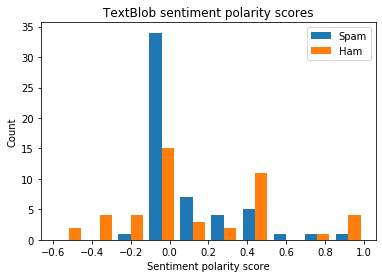

In [31]:
import matplotlib.pyplot as plt

spam_polarities = [
    textblob_sentiment(x).polarity for _, x in df_dev.iterrows() if x.label == SPAM
]

ham_polarities = [
    textblob_sentiment(x).polarity for _, x in df_dev.iterrows() if x.label == HAM
]

plt.hist([spam_polarities, ham_polarities])
plt.title("TextBlob sentiment polarity scores")
plt.xlabel("Sentiment polarity score")
plt.ylabel("Count")
plt.legend(["Spam", "Ham"])
plt.show()

In [32]:
@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    return HAM if x.polarity > 0.9 else ABSTAIN

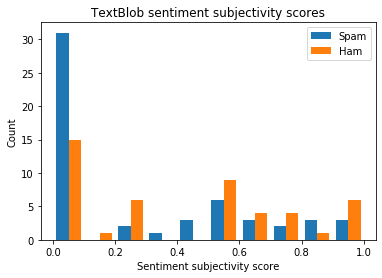

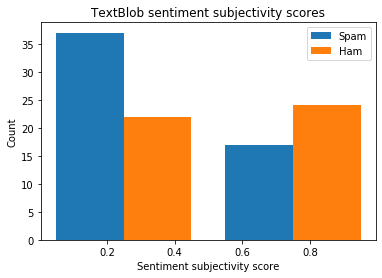

In [33]:

spam_subjectivities = [
    textblob_sentiment(x).subjectivity for _, x in df_dev.iterrows() if x.label == SPAM
]

ham_subjectivities = [
    textblob_sentiment(x).subjectivity for _, x in df_dev.iterrows() if x.label == HAM
]

plt.hist([spam_subjectivities, ham_subjectivities])
plt.title("TextBlob sentiment subjectivity scores")
plt.xlabel("Sentiment subjectivity score")
plt.ylabel("Count")
plt.legend(["Spam", "Ham"])
plt.show()

plt.hist([spam_subjectivities, ham_subjectivities], bins=[0, 0.5, 1])
plt.title("TextBlob sentiment subjectivity scores")
plt.xlabel("Sentiment subjectivity score")
plt.ylabel("Count")
plt.legend(["Spam", "Ham"])
plt.show()

In [34]:
@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    return HAM if x.subjectivity >= 0.5 else ABSTAIN

In [35]:
lfs = [textblob_polarity, textblob_subjectivity]

applier = PandasLFApplier(lfs)
L_train = applier.apply(df_train)
L_dev = applier.apply(df_dev)

/home/srimugunthan/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 100/100 [00:00<00:00, 11163.97it/s]


In [36]:
LFAnalysis(L_train, lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
textblob_polarity,0,[0],0.035309,0.013871,0.0
textblob_subjectivity,1,[0],0.357503,0.013871,0.0


In [37]:

from snorkel.labeling import LabelingFunction


def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN


def make_keyword_lf(keywords, label=SPAM):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )


"""Spam comments talk about 'my channel', 'my video', etc."""
keyword_my = make_keyword_lf(keywords=["my"])

"""Spam comments ask users to subscribe to their channels."""
keyword_subscribe = make_keyword_lf(keywords=["subscribe"])

"""Spam comments post links to other channels."""
keyword_link = make_keyword_lf(keywords=["http"])

"""Spam comments make requests rather than commenting."""
keyword_please = make_keyword_lf(keywords=["please", "plz"])

"""Ham comments actually talk about the video's content."""
keyword_song = make_keyword_lf(keywords=["song"], label=HAM)

In [38]:
@labeling_function()
def short_comment(x):
    """Ham comments are often short, such as 'cool video!'"""
    return HAM if len(x.text.split()) < 5 else ABSTAIN

In [39]:
from snorkel.preprocess.nlp import SpacyPreprocessor

# The SpacyPreprocessor parses the text in text_field and
# stores the new enriched representation in doc_field
spacy = SpacyPreprocessor(text_field="text", doc_field="doc", memoize=True)

In [40]:
@labeling_function(pre=[spacy])
def has_person(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN

In [41]:
from snorkel.labeling.lf.nlp import nlp_labeling_function


@nlp_labeling_function()
def has_person_nlp(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN

In [42]:
lfs = [
    keyword_my,
    keyword_subscribe,
    keyword_link,
    keyword_please,
    keyword_song,
    regex_check_out,
    short_comment,
    has_person_nlp,
    textblob_polarity,
    textblob_subjectivity,
]

In [43]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_dev = applier.apply(df=df_dev)
L_valid = applier.apply(df=df_valid)

/home/srimugunthan/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 120/120 [00:01<00:00, 77.71it/s]


In [44]:
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y=Y_dev)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
keyword_my,0,[1],0.22,0.22,0.14,19,3,0.863636
keyword_subscribe,1,[1],0.14,0.12,0.06,14,0,1.000000
keyword_http,2,[1],0.10,0.08,0.07,10,0,1.000000
keyword_please,3,[1],0.10,0.10,0.06,10,0,1.000000
keyword_song,4,[0],0.16,0.12,0.06,11,5,0.687500
regex_check_out,5,[1],0.29,0.22,0.17,29,0,1.000000
short_comment,6,[0],0.28,0.18,0.07,19,9,0.678571
has_person_nlp,7,[0],0.09,0.07,0.02,6,3,0.666667
textblob_polarity,8,[0],0.05,0.05,0.01,4,1,0.800000
textblob_subjectivity,9,[0],0.41,0.33,0.20,24,17,0.585366


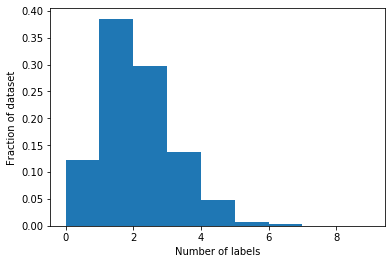

In [45]:

def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

In [46]:

from snorkel.labeling import MajorityLabelVoter

majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

In [47]:
preds_train

array([ 1,  1, -1, ...,  1,  1,  1])

In [48]:
from snorkel.labeling import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, lr=0.001, log_freq=100, seed=123)

In [49]:
majority_acc = majority_model.score(L=L_valid, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_valid, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   82.5%
Label Model Accuracy:     86.7%


In [50]:
probs_dev = majority_model.predict_proba(L=L_dev)
preds_dev = probs_dev >= 0.5
buckets = get_label_buckets(Y_dev, preds_dev[:, 1])

df_fn_dev = df_dev[["text", "label"]].iloc[buckets[(SPAM, HAM)]]
df_fn_dev["probability"] = probs_dev[buckets[(SPAM, HAM)], 1]



In [51]:
df_fn_dev.sample(5, random_state=3, replace=True)

,text,label,probability
334,Check out Em&#39;s dope new song monster here:...,1,0.0
313,Aslamu Lykum... From Pakistan﻿,1,0.0
189,/watch?v=aImbWbfQbzg watch and subscrible,1,0.0
313,Aslamu Lykum... From Pakistan﻿,1,0.0
313,Aslamu Lykum... From Pakistan﻿,1,0.0


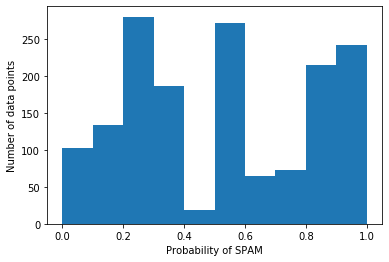

In [52]:
def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of SPAM")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, SPAM])

In [53]:
from snorkel.labeling import filter_unlabeled_dataframe

df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

In [54]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 2))
X_train = vectorizer.fit_transform(df_train_filtered.text.tolist())

X_dev = vectorizer.transform(df_dev.text.tolist())
X_valid = vectorizer.transform(df_valid.text.tolist())
X_test = vectorizer.transform(df_test.text.tolist())

In [55]:
import random

import numpy as np
import tensorflow as tf


seed = 1
np.random.seed(seed)
random.seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, inter_op_parallelism_threads=1
)

from tensorflow.keras import backend as K

tf.set_random_seed(seed)
sess = tf.compat.v1.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [59]:
import glob
import os
import subprocess
from collections import OrderedDict

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [60]:
def get_keras_logreg(input_dim, output_dim=2):
    model = tf.keras.Sequential()
    if output_dim == 1:
        loss = "binary_crossentropy"
        activation = tf.nn.sigmoid
    else:
        loss = "categorical_crossentropy"
        activation = tf.nn.softmax
    dense = tf.keras.layers.Dense(
        units=output_dim,
        input_dim=input_dim,
        activation=activation,
        kernel_regularizer=tf.keras.regularizers.l2(0.001),
    )
    model.add(dense)
    opt = tf.keras.optimizers.Adam(lr=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
    return model

In [61]:
def get_keras_early_stopping(patience=10, monitor="val_acc"):
    """Stops training if monitor value doesn't exceed the current max value after patience num of epochs"""
    return tf.keras.callbacks.EarlyStopping(
        monitor=monitor, patience=patience, verbose=1, restore_best_weights=True
    )


In [62]:
from snorkel.analysis import metric_score
from snorkel.utils import preds_to_probs


# Define a vanilla logistic regression model with Keras
keras_model = get_keras_logreg(input_dim=X_train.shape[1])

keras_model.fit(
    x=X_train,
    y=probs_train_filtered,
    validation_data=(X_valid, preds_to_probs(Y_valid, 2)),
    callbacks=[get_keras_early_stopping()],
    epochs=50,
    verbose=0,
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping


In [63]:
preds_test = keras_model.predict(x=X_test).argmax(axis=1)
test_acc = metric_score(golds=Y_test, preds=preds_test, metric="accuracy")
print(f"Test Accuracy: {test_acc * 100:.1f}%")

Test Accuracy: 92.0%


In [64]:
keras_dev_model = get_keras_logreg(input_dim=X_train.shape[1], output_dim=1)

keras_dev_model.fit(
    x=X_dev,
    y=Y_dev,
    validation_data=(X_valid, Y_valid),
    callbacks=[get_keras_early_stopping()],
    epochs=50,
    verbose=0,
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping


In [65]:
preds_test_dev = np.round(keras_dev_model.predict(x=X_test))
test_acc = metric_score(golds=Y_test, preds=preds_test_dev, metric="accuracy")
print(f"Test Accuracy: {test_acc * 100:.1f}%")

Test Accuracy: 92.8%


In [66]:
from snorkel.utils import probs_to_preds

preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

In [67]:
from sklearn.linear_model import LogisticRegression

sklearn_model = LogisticRegression(C=0.001, solver="liblinear")
sklearn_model.fit(X=X_train, y=preds_train_filtered)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [68]:

print(f"Test Accuracy: {sklearn_model.score(X=X_test, y=Y_test) * 100:.1f}%")

Test Accuracy: 93.2%
